In [1]:
from src import *

In [2]:
from nilearn.connectome import ConnectivityMeasure
from brainspace.gradient import GradientMaps
import seaborn as sns

## Description

We investigate the dynamic gradients connectivity for single acquisitions. (i.e we process at individual level) Looking at aligned gradient's centroid and concentration

GOAL: Visualize over time topology change of connectivity gradients and analysing region clusters' shifts and concentration

## Table of Contents
- [Standard Sliding window Dynamic (Visualization)](#sliding)

- [Standard Sliding window Dynamic (Analysis)](#slidinganalysis)

In [3]:
# Loading gradients 
subject_grad = load('./resources/static_grad/Rest_grad.pkl')

In [4]:
behavioural = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
behavioural.columns[-15:]

Index(['cov_total', 'DASS_dep', 'DASS_anx', 'DASS_str', 'bas_d', 'bas_f',
       'bas_r', 'bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu',
       'BIG5_ope', 'erq_cr', 'erq_es'],
      dtype='object')

#### Data Splitting: training / validation
We split accordingly to have the same number of above-mean and below-mean points

In [45]:
# feature of interest
grad_idx = 0
feat     = "erq_es"
cutoff   = behavioural[['ID', feat]].mean().iloc[0]
nb_above = np.sum(np.array(list(behavioural[feat])) > cutoff)
nb_below = np.sum(np.array(list(behavioural[feat])) <= cutoff)

np.random.seed(0)
a = np.random.choice(np.where(behavioural[feat] > cutoff)[0], int(nb_above/2), replace=False)
b = np.random.choice(np.where(behavioural[feat] <= cutoff)[0], int(nb_below/2), replace=False)

trainIds = list(behavioural.ID.iloc[a]) + list(behavioural.ID.iloc[b])
valIds   = [b for b in list(behavioural.ID) if b not in trainIds]

# We use first gradient as a point
X_train = np.asarray([subject_grad[t][:,grad_idx] for t in trainIds])
y_train = np.asarray([behavioural[behavioural.ID == t][feat].iloc[0] for t in trainIds])

X_val = np.asarray([subject_grad[t][:,grad_idx] for t in valIds])
y_val = np.asarray([behavioural[behavioural.ID == t][feat].iloc[0] for t in valIds])

/var/folders/95/vrc1ltz17tn5l8mk269kgjc80000gn/T/ipykernel_84247/1273550098.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  cutoff   = behavioural[['ID', feat]].mean().iloc[0]


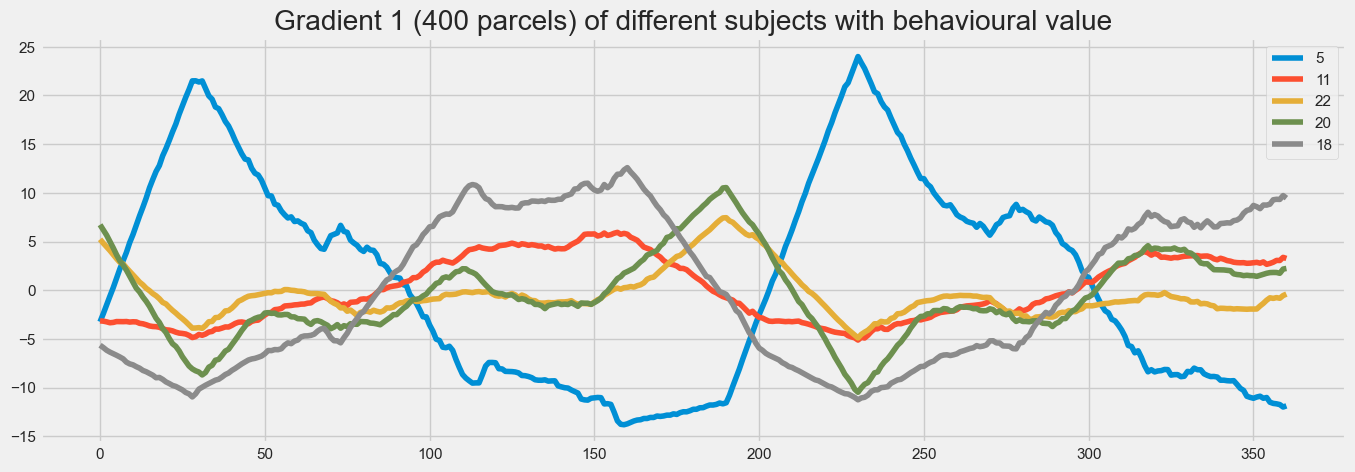

In [46]:
# forcing the style since sns changes it when we call default set size
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,5))
sw = 40
plt.plot(overlap_add(X_train[8], sw), label=y_train[8])
plt.plot(overlap_add(X_train[9], sw), label=y_train[9])
plt.plot(overlap_add(X_train[1], sw), label=y_train[1])
plt.plot(overlap_add(X_train[6], sw), label=y_train[6])
plt.plot(overlap_add(X_train[4], sw), label=y_train[4])
plt.title("Gradient 1 (400 parcels) of different subjects with behavioural value")
plt.legend()

#### Visual difference

In [47]:
ordered = [x for _, x in sorted(zip(y_train, trainIds), key=lambda pair: pair[0])]
G1 = []
G2 = []
coloring = []

for i in range(len(ordered)):
    G1 += list(subject_grad[ordered[i]][:,0])
    G2 += list(subject_grad[ordered[i]][:,1])
    coloring += [np.sort(y_train)[i]] * 400

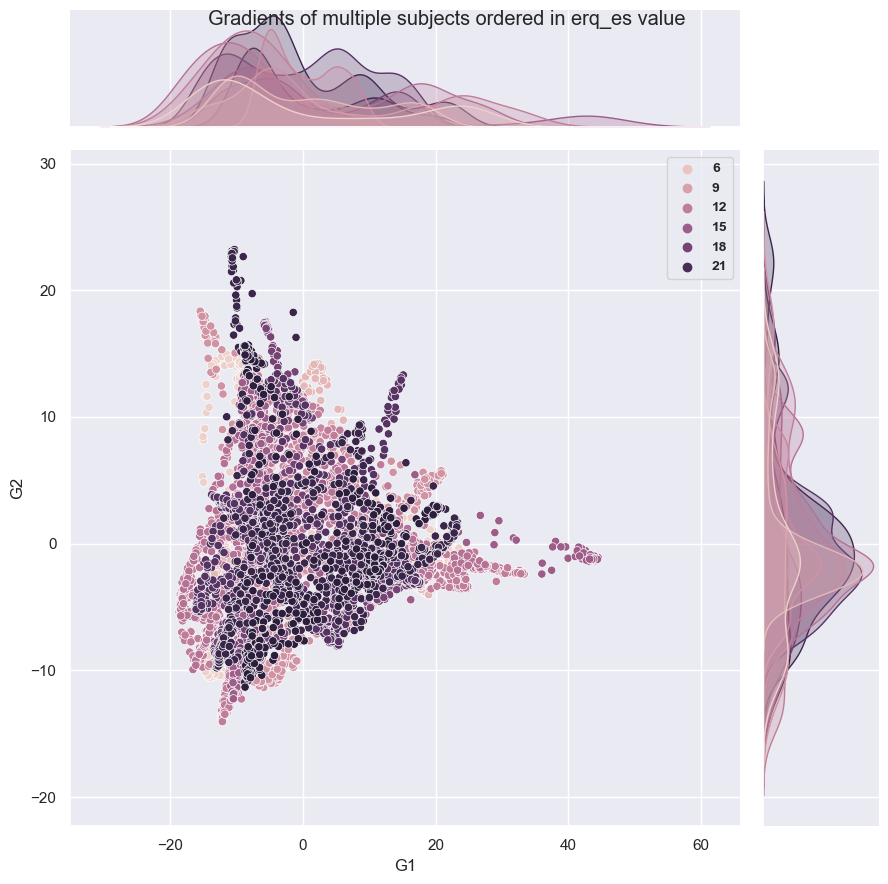

In [48]:
sns.set(rc={'figure.figsize':(30,30)})

tmp_df = {"G1": G1 , "G2": G2, feat: coloring}


ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue=feat, height=9)
ax.fig.suptitle("Gradients of multiple subjects ordered in {} value".format(feat))
legend_properties = {'weight':'bold','size':10}
ax.ax_joint.legend(prop=legend_properties,loc='upper right')

#### Regress / Predictive

Method 1: SVM

In [170]:
from sklearn import svm

In [171]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
y_normal = zscore(y_train)
regr.fit(X_train, y_normal)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

Text(0.5, 1.0, 'training fit process')

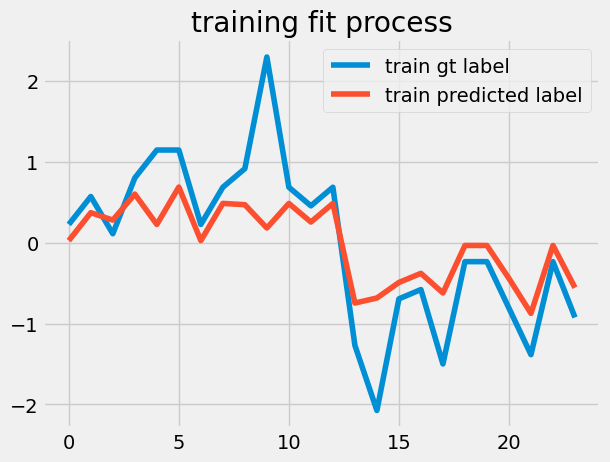

In [172]:
plt.plot(y_normal, label='train gt label')
plt.plot(regr.predict(X_train), label='train predicted label' )
plt.legend()
plt.title('training fit process')

Text(0.5, 1.0, 'validation fit process')

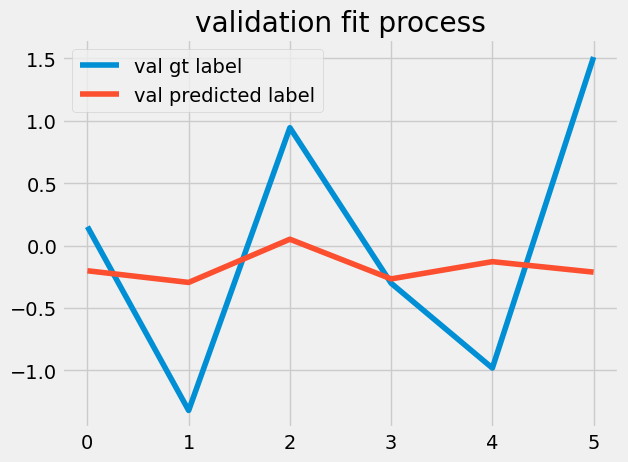

In [173]:
plt.plot(zscore(y_val), label='val gt label')
plt.plot(regr.predict(X_val), label='val predicted label')
plt.legend()
plt.title('validation fit process')